## Murcko Scaffolds

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

In [29]:
import deepchem
from rdkit import Chem

### Load the data

In [3]:
pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_1.pkl'

if  os.path.isfile(pkl_file):
    # this dataset was computed as df_dims_mds in the 2_Comparing...ipynb 
     df_all_mols = pd.read_pickle(pkl_file)

### Murcko Scaffolds

In [4]:
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.Chem import MolToSmiles
from rdkit.Chem import rdDepictor

In [5]:
# Define a lambda function to compute Murcko scaffolds
def scaffold2smiles(mol, generic, return_smiles = True):
    ''' Returns a SMILES string representing the Murcko Scaffold of a given molecule'''
    if generic:
        # Makes a Murcko scaffold generic (all atoms -> carbon and all bonds -> single)
        scff = MurckoScaffold.MakeScaffoldGeneric(mol)
        scff = MurckoScaffold.GetScaffoldForMol(scff)
        scff_smiles = MolToSmiles(scff)
    else:
        # Return a smiles scaffold 
        try:
            scff = MurckoScaffold.GetScaffoldForMol(mol)
            scff_smiles =  MolToSmiles(scff)
        except:
            scff_smiles = np.nan
            scff = np.nan
    if return_smiles:
        return scff_smiles
    else:
        return scff

In [6]:
# ************
# Function to compute 2d coords
# ************
to2d = Chem.rdDepictor.Compute2DCoords

#### Compute Murcko Scaffolds

In [7]:
%%time
# Compute Generic Murko Scaffolds
generic_murcko_smiles = [scaffold2smiles(mol, generic=True, return_smiles=True) 
                         for mol in df_all_mols.mol_rdk]

# Compute Murcko Scaffolds as SMILES
murcko_smiles = [scaffold2smiles(mol, generic=False, return_smiles=True) 
                 for mol in df_all_mols.mol_rdk]

RDKit ERROR: [15:49:03] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 10 C, 6, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 17 C, 6, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [15:49:03] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [15:49:04] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [15:49:04] Explicit valence for atom # 13 N, 4, is greater than permitted


CPU times: user 14.8 s, sys: 260 ms, total: 15.1 s
Wall time: 15 s


### Create a dataframe

In [8]:
df_murcko = df_all_mols[['name', 'library', 'Activity', 'mol_rdk']].copy()
df_murcko['scff'] = murcko_smiles
df_murcko['scff_generic'] = generic_murcko_smiles

# Converto molecule coordinates to 2d
df_murcko['mol_rdk_2'] = df_murcko['mol_rdk']
df_murcko['mol_rdk_2'].apply(to2d)
df_murcko.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 7 columns):
name            5839 non-null object
library         5839 non-null object
Activity        5839 non-null object
mol_rdk         5839 non-null object
scff            5830 non-null object
scff_generic    5839 non-null object
mol_rdk_2       5839 non-null object
dtypes: object(7)
memory usage: 319.4+ KB


#### Number of regular scaffolds

In [9]:
# Number of unique molecules
print('Number of different regular Scaffolds:', df_murcko.scff.unique().size)

Number of different regular Scaffolds: 3984


In [10]:
df_murcko['scff'].value_counts().head()

c1ccc(Nc2nnc(-c3ccccc3)c3ccccc23)cc1                52
O=C(NCc1ccccc1)c1cc2ccccc2n1Cc1ccccc1               41
O=C(CSc1nnc(-c2ccccc2)n1-c1ccccc1)Nc1ccccc1         30
C=C(NNC(=O)c1cccc(S(=O)(=O)Nc2ccccc2)c1)c1ccccc1    29
O=C(CSc1nnc(-c2ccccc2)[nH]1)Nc1ccccc1               25
Name: scff, dtype: int64

#### Number of generic scaffolds

In [11]:
print('Number of different generic Scaffolds:', df_murcko.scff_generic.unique().size)

Number of different generic Scaffolds: 2507


In [12]:
df_murcko['scff_generic'].value_counts().head()

C1CCC(CCCCC2CCC(CCC3CCCCC3)CC2)CC1           86
C1CCC(CCCC2CC3CCCCC3C2CC2CCCCC2)CC1          63
C1CCC(CCCCC2CCCC(CCC3CCCCC3)C2)CC1           60
C1CCC(CCCCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1    55
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1              52
Name: scff_generic, dtype: int64

#### Length of generic scaffold SMILES

In [13]:
# Count the number of molecules inside each scaffolds
scff_counts = df_murcko['scff_generic'].value_counts()
# Get the lenght of the gemeric Scaffold
scff_smiles_len = scff_counts.index.map(len)
# Create a dataframe of unique scaffolds
df_scff_counts = pd.DataFrame({'counts': scff_counts, 'length': scff_smiles_len})
# Sort by length 
df_scff_counts.sort_values('length', inplace=True)
df_scff_counts.head(5)

,counts,length
,1,0
C1CCCC1,3,7
C1CCCCC1,8,8
C1CC2CCCC2C1,2,12
C1CCC2CCCC2C1,3,13


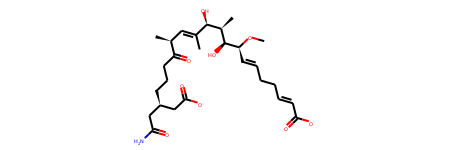

In [14]:
# This molecule doesn't have a Murcko Scaffold (its
df_murcko[df_murcko['scff_generic'] == '']
df_murcko.loc[678, 'mol_rdk']

In [15]:
# How many scaffolds have more than five molecules?
sum(scff_counts > 5)

167

### Visualize Generic Scaffolds against Normal Scaffolds

In [16]:
# Function to get mol from scaffold smiles
fromSmiles = Chem.MolFromSmiles

#### First Example

In [17]:
# Helper function to visualize examples
def _draw_scaffolds(idx):
    labels = ['Original', 'Regular Scff.', 'Generic Scff.']
    original = df_all_mols.loc[idx, 'mol_rdk']
    normal = fromSmiles(df_murcko.loc[idx, 'scff'])
    generic = fromSmiles(df_murcko.loc[idx, 'scff_generic'])
    mols = [original, normal, generic]
    return Chem.Draw.MolsToGridImage(mols=mols, legends=labels)

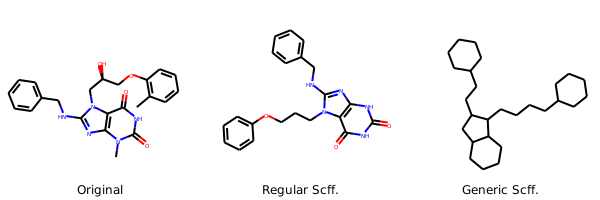

In [18]:
_draw_scaffolds(1759)

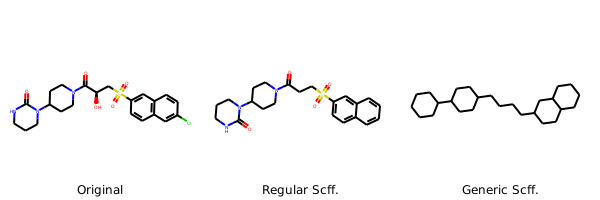

In [19]:
_draw_scaffolds(100)

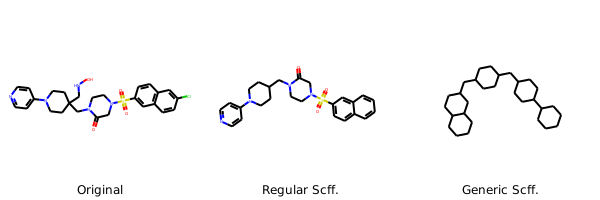

In [20]:
_draw_scaffolds(10)

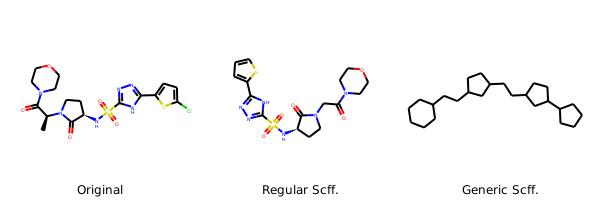

In [21]:
_draw_scaffolds(50)

## Draw most populated generic scaffolds

In [22]:
most_freq_scff = df_murcko['scff_generic'].value_counts().head(28)
most_freq_scff

C1CCC(CCCCC2CCC(CCC3CCCCC3)CC2)CC1              86
C1CCC(CCCC2CC3CCCCC3C2CC2CCCCC2)CC1             63
C1CCC(CCCCC2CCCC(CCC3CCCCC3)C2)CC1              60
C1CCC(CCCCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1       55
C1CCC(CCCCC2CCC(C3CCCCC3)C2)CC1                 52
C1CCC(CC2CCC(C3CCCCC3)C3CCCCC23)CC1             52
C1CCC(CCCCC2CCC(CCC3CCCC3)CC2)CC1               45
C1CCC(CCCCC2CCC(C3CCCCC3)C2C2CCCCC2)CC1         43
C1CCC(CCC2CCCC(CCCCC3CCCCC3)C2)CC1              42
C1CCC(CCCCC2CCC(CCC3CCCCC3)C2)CC1               34
C1CCC(CCC(CCCCC2CCCCC2)C2CCCC3CCCCC32)CC1       32
C1CCC(CCC2CCCC(CCC3CCCCC3)C2)CC1                32
C1CCC(CCC2CCC(CCC3CCCCC3)CC2)CC1                32
C1CCC(CCC2CC3CCCCC3CC2CC2CCCCC2)CC1             32
C1CCC(CCCC(CC2CCCCC2)C2CCCCC2)CC1               31
C1CCC(CCCCC2CCC(C3CCCC3)C2C2CCCCC2)CC1          30
C1CCC(CCCCCCC2CC3CCCCC3CC2C2CCCCC2)CC1          29
C1CCC(CCCCCC2CCC(CCC3CCCCC3)CC2)CC1             27
C1CCC(CC2CCC(C3CCCCC3)C3CCCCC32)CC1             26
C1CCC2C(C1)CCC1C3CCCC3CCC21    

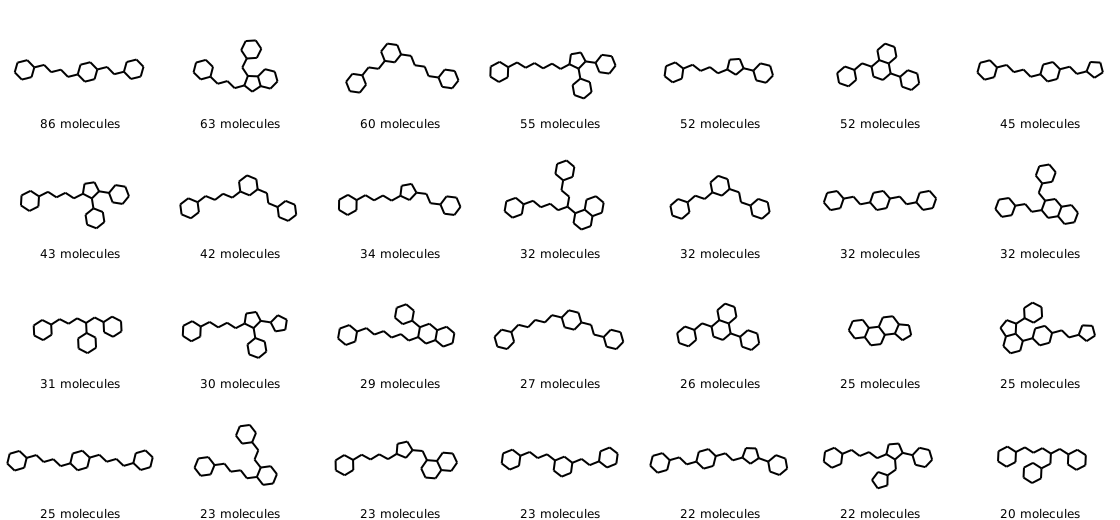

In [23]:
mols = [fromSmiles(mol) for mol in most_freq_scff.index.values]
num_mols_per_scff = [f'{n_mols} molecules' for n_mols in most_freq_scff]
Chem.Draw.MolsToGridImage(mols=mols, molsPerRow=7, legends=num_mols_per_scff, subImgSize=(160,130))

***
# Use DeepChem to compute the Scaffold splitting

Sources:
-  https://deepchem.io/docs/_modules/deepchem/splits/splitters.html
-  https://deepchem.io/deepchem.splits.html
- https://github.com/pandegroup/deepchem_enf/blob/master/deepchem/utils/featurize.py

### Split function used by deepchem

```python
def split(self,
            dataset,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=1000): # Usa la función log para guardar
    """
        Splits internal compounds into train/validation/test by scaffold.
        """
    #** 
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    
    #** Crea un diccionario vacío
    scaffolds = {}
    log("About to generate scaffolds", self.verbose)
    data_len = len(dataset)
    
    #** El objeto de la clase Dataset tiene como atributo ids al smiles de la molécula
    for ind, smiles in enumerate(dataset.ids): 
      if ind % log_every_n == 0:
        log("Generating scaffold %d/%d" % (ind, data_len), self.verbose)
        
      # Genera los scaffolds de Murcko
      scaffold = generate_scaffold(smiles) # La función implementa MurckoScaffoldSmiles
        # Con lo cual, no da opción de Scaffolds genéricos, y sólo funciona desde SMILES
        
      #********************
      # La clave para ir llenando los bins está aquí
      #********************
      if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind] # Crea una nueva entrada si el scaffold no ha sido 'visto'
        # El key es el scaffold y el value es una lista con el índice de la primera ocurrencia
      else:
        scaffolds[scaffold].append(ind) # Si el scaffold ya existe, añade el índice de la ocurrencia
        
    # Ordena los índices de las moléculas que pertenecen a cada scaffold
    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    
    # Crea una lista con las listas de los índices de cada scaffold
    # Ordenando por longitud del número de índices en el set, y por el valor del primer índice
    # Cada scaffold_set es una lista de índices que pertenecen a un scaffold en particular
    scaffold_sets = [
        scaffold_set
        for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    # La longitud del Train set se establece según la longitud del dataset
    train_cutoff = frac_train * len(dataset)
    valid_cutoff = (frac_train + frac_valid) * len(dataset)
    # Se crean las listas vacias de los tres sets
    # Cuando no se requiere el set de validación, se omite estableciendo el frac_valid = 0
    train_inds, valid_inds, test_inds = [], [], []
    log("About to sort in scaffold sets", self.verbose)
    
    # Por cada scaffold_set:
    for scaffold_set in scaffold_sets:
      # Si lo que hay ya en train_inds más el scaffold_set es mayor al cutoff para el train set 
      if len(train_inds) + len(scaffold_set) > train_cutoff:
        # Lo mismo para el valid set
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
          test_inds += scaffold_set
        else:
          valid_inds += scaffold_set
      else:
        train_inds += scaffold_set
        
    return train_inds, valid_inds, test_inds
```

### Compute ScaffoldSplitter
1. ScaffoldSplitter requires a `dataset` object from class Dataset.
2. Murcko Scaffolds are computed only from SMILES format ([Source code](https://github.com/pandegroup/deepchem_enf/blob/master/deepchem/utils/featurize.py))

#### Create the dataset object

In [24]:
from deepchem.data import NumpyDataset 
from rdkit import Chem

In [25]:
# Molecules are required in SMILES format
df_dataset = df_murcko[['scff_generic', 'scff', 'name']].copy() # X dataset
df_dataset['y'] = [1 if i == 'active' else 0 for i in df_murcko.Activity] # target value
df_dataset['smiles'] = [Chem.MolToSmiles(mol) for mol in df_murcko.mol_rdk] # ids values

# Print some properties
print('Number of molecules:', df_dataset.shape[0])
print('Number of actives:', df_dataset.y.sum())

# Create the deepchem dataset
dataset_g = NumpyDataset(X = df_dataset.drop('y', axis=1), # Features set
                         y = df_dataset['y'], # Target values
                         ids=df_dataset['scff_generic']) # SMILES should be column ids

Number of molecules: 5839
Number of actives: 300


In [26]:
from deepchem.splits.splitters import ScaffoldSplitter

In [27]:
x_g = ScaffoldSplitter().train_test_split(dataset_g)
x_g

(<deepchem.data.datasets.NumpyDataset at 0x7f5dcab76a90>,
 <deepchem.data.datasets.NumpyDataset at 0x7f5da4621dd0>)

#### Training and Test sets

In [28]:
# Training set
X_train, y_train = x_g[0].X, x_g[0]._y
print('Training set shape', X_train.shape)
print('Number of actives in y_train:', y_train.sum())

# Test set 
X_test, y_test = x_g[1].X, x_g[1]._y
print('Test set shape', X_test.shape)
print('Number of actives in y_test:', y_test.sum())

Training set shape (4671, 4)
Number of actives in y_train: 232
Test set shape (1168, 4)
Number of actives in y_test: 68
